# Homework 1
The goal of this homework is to make sure that you have your environment set up, and get a little bit of practice with pytorch. Some of the examples and tutorial components are helpfully drawn from the [UVA DL course](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

import torch
print("Using torch", torch.__version__)

Using torch 2.4.0


Generally, we want all of our code to be reproducible, so we're going to set a random number generator seed. This will make sure that our random initializations are the same every time we run the code. This is important for reproducibility. Why? Well, if you get some kind of error then this error will deterministically happen which makes debugging easier for you and anyone else who might try to help you!

In [2]:
torch.manual_seed(0)

# An introduction to PyTorch
You can think of PyTorch as Numpy + autodifferentiation. That means, it has a numpy-like syntax but also allows you to take derivatives of arbitrary differentiable functions. 

The core object in PyTorch is the Tensor. A Tensor is the equivalent of a numpy array but with a few extra features. For example, you can move a tensor to the GPU to speed up computation and operation on tensors are tracked to build a computation graph. This allows you to take the derivative of a tensor with respect to some other tensor.

## Playing around with tensors
Here are some basic tensor operations that you'll use pretty often
- `torch.zeros`: Creates a tensor filled with zeros
- `torch.ones`: Creates a tensor filled with ones
- `torch.rand`: Creates a tensor with random values uniformly sampled between 0 and 1
- `torch.randn`: Creates a tensor with random values sampled from a normal distribution with mean 0 and variance 1
- `torch.arange`: Creates a tensor containing the values in the indicated range
- `torch.tensor` (input list): Creates a tensor from the list elements you provide

In [3]:
## Some examples
print('a tensor filled with 1, 2, 3')
x = torch.tensor([1, 2, 3])
print(x)
print(x.size())

print(' a 2x3 tensor filled with zeros')
x = torch.zeros((2, 3))
print(x)
print(x.size())

a tensor filled with 1, 2, 3
tensor([1, 2, 3])
torch.Size([3])
 a 2x3 tensor filled with zeros
tensor([[0., 0., 0.],
        [0., 0., 0.]])
torch.Size([2, 3])


## Interoperability with numpy
Often-times we'll want to do a bunch of pytorch operations but in the end export things to Numpy so that we can plot in matplotlib or do some other operation. PyTorch tensors can be converted to numpy arrays and vice-versa very easily.

- `tensor.numpy()`: Converts a torch Tensor to a numpy array
- `torch.from_numpy()`: Converts a numpy array to a torch Tensor
so for example if you have a torch tensor `a` you can call `a.numpy()` to get a numpy array.
or if you have a numpy tensor b you can call `torch.from_numpy(b)` to get a torch tensor or `torch.tensor(b)`.

In [4]:
import numpy as np
b = np.array([1, 2, 3])
x = torch.tensor(b)
x = torch.from_numpy(b)
c = x.numpy()

## Basic and important operations
Torch supports all sorts of standard operations like in numpy. You can add and subtract tensors together, multiply them by a constant, etc. However, the operations we will care the most about are matrix multiplies. In PyTorch, you can do a matrix multiply by using the `torch.matmul` function or the `@` operator (which is syntactic sugar for torch.matmul i.e. equivalent to calling torch.matmul). You can also do elementwise multiplication using the `*` operator.

In [5]:
a = torch.ones((2,3))
b = torch.ones((3))
c = a@b
print(c)

tensor([3., 3.])


Importantly, these matrix operations can be broadcasted or batched. Often-times (you'll see) we want to take a single matrix and apply it to a lot of data. For example, we might have an NxP matrix and M datapoints of shape (M, P). For each of the datapoints, we want to form the matrix-vector product. One way we could do this is to simply iterate through the data-points one at a time and multiply the matrix by the vector. However, this is very slow. Instead, we want to use what's known as `broadcasting` to multiply them all in one operation. Broadcasting takes an additional dimension and expands the operation over it. 

We can multiply the matrix by all of the datapoints at once using broadcasting. The two syntaxes for doing this are:
- torch.matmul(a, b)
- a@b
    
where a is a tensor of shape (N, P) and b is a tensor of shape (P, M, 1). The result will be a tensor of shape (N, M, 1).

In [6]:
import time
# an example of matrix multiplication broadcasting
num_data = 10000
matrix = torch.ones((5,4))
vector = torch.ones(((num_data,4, 1)))

# first lets do this in a for loop
t = time.time()
for index in range(vector.shape[0]):
    matrix @ vector[index]
loop_time = time.time()-t
print('time to for loop ', loop_time)

# then lets broadcast it
t = time.time()
(matrix @ vector).shape
broadcast_time = time.time()-t
print('time to broadcast ', broadcast_time)
print(f'broadcasting is {loop_time / broadcast_time} times faster')

# for you to fill in - can you do the same thing but for a dot product operation instead? That is, we have a vector of size (num_data, N) and we want to dot product it with a vector of size (N, 1).


time to for loop  0.045504093170166016
time to broadcast  0.005227088928222656
broadcasting is 8.705436964057654 times faster


## Indexing
Just like in numpy, we often want to index into tensors. This is done using the square bracket notation. For example, if we have a tensor `a` we can get the first element by calling `a[0]`. We can also get a range of elements by calling `a[1:3]` or access a specific axis as `a[1,:]` which for a 2-d tensor will take the 1st element of the first axis and return all the other axes. We can also use boolean indexing to get all elements that satisfy a certain condition. For example, if we want all elements greater than 3 we can call `a[a > 3]`.

One of the cool things in PyTorch is that tensor operations can easily be differentiated. Each tensor has a `requires_grad` attribute, and if it is set to True, then operations on the tensor will be tracked. You can then call `.backward()` on the final tensor to compute the gradients of that tensor with respect to all the tensors that have `requires_grad` set to True. This is a very powerful feature that allows us to easily compute gradients of complex functions. Lets see an example of this below.

In [7]:
# Float32 means that the tensor is represented by 32 bits. It can roughly represent numbers between -3.4e38 and 3.4e38 and can represent about 7 decimal places. Later, we'll go into why we care about how many decimals can be represented. Note that by default when you construct a tensor that requires_grad is False.
x = torch.arange(3, dtype=torch.float32, requires_grad=True) 
a = x + 2
b = a ** 2
c = b + 3
y = c.mean()
print("Y", y)

# we can inspect each of the intermediate variables
# to see what gradient function is associated with each
print(x.grad_fn)
print(a.grad_fn)
print(b.grad_fn)
print(c.grad_fn)

# if we call backward on y, we are asking pytorch to compute the gradient of y with respect to all the tensors that have requires_grad=True. This should be all of them because they are all dependent on x.
y.backward()
print(x.grad) # the gradient of y with respect to x

Y tensor(12.6667, grad_fn=<MeanBackward0>)
None
tensor([1.3333, 2.0000, 2.6667])


This computation graph looks like

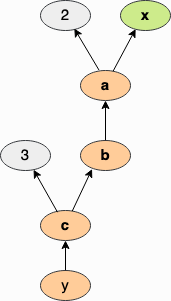

where the arrows point in the direction of the gradient flow and variables that have derivatives are colored orange.

How is this gradient computed? Well, it's basically done by the chain rule.
$$\frac{dy}{dx} = \frac{dy}{du} \frac{du}{dx}$$
where $u$ is some intermediate variable. This is done recursively for all the intermediate variables. So extending it out we have
$$\frac{dy}{dx_i} = \frac{dy}{dc_i} \frac{dc_i}{db_i} \frac{db_i}{da_i} \frac{da_i}{dx_i}$$
Note the indices, some of these variables are vectors. 
and if we do all those out we have
$$\frac{da_i}{dx_i} = 1$$
$$\frac{db_i}{da_i} = 2a_i$$
$$\frac{dc_i}{db_i} = 1$$
$$\frac{dy}{dc_i} = 1/3$$
and if you multiple this out you should get the right thing. 

# Question 1 - Gradient Descent practice
In lecture 1 (in the notes), we learned about gradient descent, a common optimization algorithm used to minimize losses in deep learning. Now lets implement gradient descent for logistic regression. Remember from the lecture notes that the predictor in logistic regression is $$p(y=1|x, \theta) = \frac{1}{1 + \exp(-w^Tx - b)}$$ where $\theta = [w,b]$. 

Now, for a given data pair ${x_i, y_i}$, the likelihood of that datapoint is given by $$L(w) = y_i \log(p(y=1|x_i)) + (1 - y_i) \log(1 - p(y=1|x_i))$$ and for the entire dataset we get the log-likelihood $$L(w) = \sum_{i=1}^N y_i \log(p(y=1|x_i)) + (1 - y_i) \log(1 - p(y=1|x_i))$$

## Part 1
Write out the gradients of the likelihood $\frac{\partial L}{\partial w}$ and $\frac{\partial L}{\partial b}$. You can write them here in the notebook using LaTex.

$$\frac{\partial L}{\partial w} = \frac{1}{N}\sum_{i=1}^N \left(\sigma(w^Tx + b) -y)\right) \cdot x$$

$$\frac{\partial L}{\partial b} = \frac{1}{N}\sum_{i=1}^N \left(\sigma(w^Tx + b) -y)\right)$$

## Part 2
I've generated the following dataset that can almost be separated by a line. Your job is to implement gradient descent to find the values of $w$ and $b$ that minimize the negative log-likelihood. Note that the data is completely linearly separable so you should still be able to get a perfect classifier.

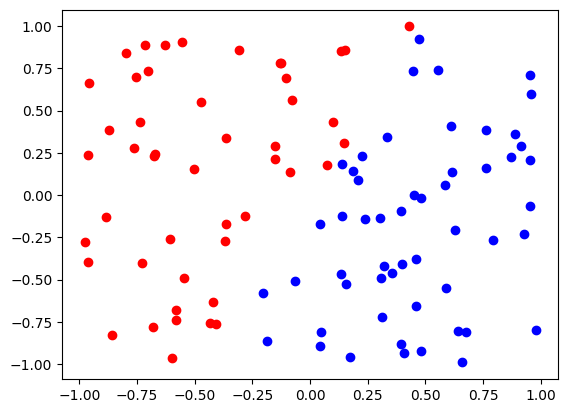

In [8]:
with open('Data/Homework_1/linear_data_x.csv', 'rb') as f:
    x = np.loadtxt(f, delimiter=',')
with open('Data/Homework_1/linear_data_y.csv', 'rb') as f:
    y = np.loadtxt(f, delimiter=',')

    
# plot the data, coloring y = 1 as red and 0 as blueß
plt.figure()
plt.scatter(x[y==1, 0], x[y==1, 1], color='red')
plt.scatter(x[y==0, 0], x[y==0, 1], color='blue')
plt.show()


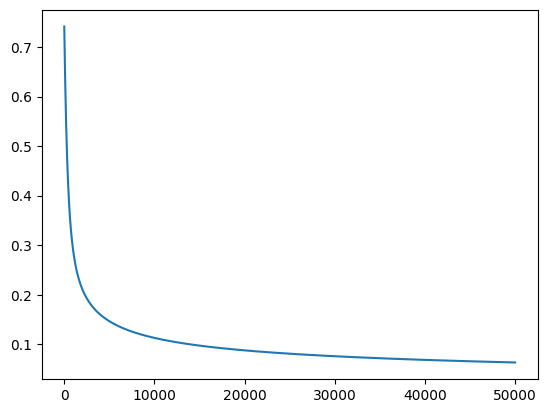

/var/folders/b7/8hhkzs5n5vx9gxwftcc2j9hh0000gn/T/ipykernel_83240/1711919950.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


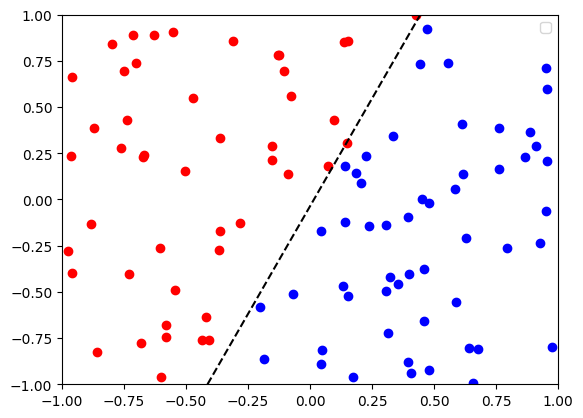

In [9]:
# implement gradient descent on the negative log likelihood yourself
# DO NOT USE TORCH YET
num_iters = 50000
lr = 0.02

# initialize the weights
w = np.random.randn(2)
b = np.random.randn()

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def nll(x, y, w, b):
    pred = sigmoid(x @ w + b)
    return -np.mean(y * np.log(pred + 1e-15) + (1 - y) * np.log(1 - pred + 1e-15))

losses = []
for i in range(num_iters):
    # forward pass
    pred = sigmoid(x @ w + b)
    loss = nll(x, y, w, b)
    losses.append(loss)

    # backward pass
    grad_w = np.mean((pred - y)[:, None] * x, axis=0)
    grad_b = np.mean(pred - y)
    
    # update weights
    w -= lr * grad_w
    b -= lr * grad_b

plt.figure()
plt.plot(losses)
plt.show()

# plot the decision boundary. This will grid over the space and evaluate the model at each point. It then plots the boundary corresponding to where the model
# predicts a 50% probability of being in class 1. 
# If you're feeling fancy, vectorize it!
plt.figure()
plt.scatter(x[y==1, 0], x[y==1, 1], color='red')
plt.scatter(x[y==0, 0], x[y==0, 1], color='blue')
x_space = np.linspace(-1, 1, 100)
y_space = np.linspace(-1, 1, 100)
X_mesh, Y_mesh = np.meshgrid(x_space, y_space)
Z = np.zeros_like(X_mesh)
for i in range(100):
    for j in range(100):
        Z[i, j] = sigmoid(np.array([X_mesh[i, j], Y_mesh[i, j]]) @ w + b)
# create a level 0 contour with a label
plt.contour(X_mesh, Y_mesh, Z, levels=[0.5], colors='black', linestyles='dashed')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.legend()
plt.show()


In [10]:
# for your convenience, here are the graphs corresponding to the right answer

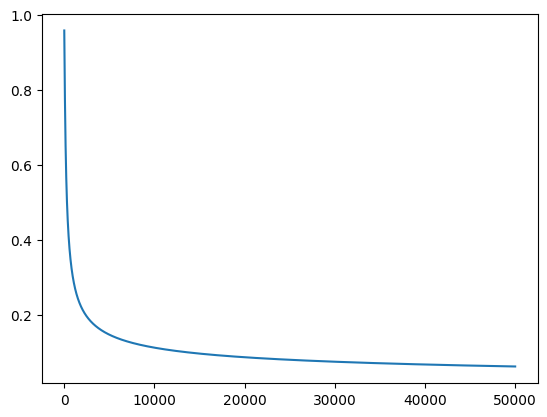
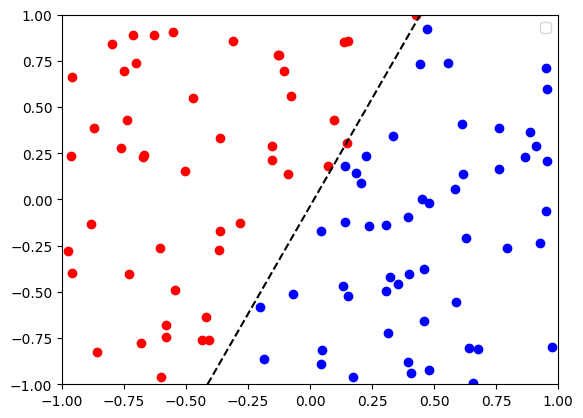

## Question 1.3 - Not linearly separable data
In the prior problem, I told you / you could see that the data could be predicted perfectly by a linear classifier. However, this is not always the case. In this problem, I've generated a dataset that cannot be separated by a line. Now one solution to this problem is to transform the data into a higher-dimensional space where it can be separated by a line. For example, given a dataset with features $x$, we could, if we wanted, create a new dataset with features $[x, x^2, x^3, x^4, x^5]$ or $[x. sin(x), 1/x]$ etc. Any transformation of the features is possible. Then, we perform our regression / classification in this new space instead of the original one. So, here we've made a dataset that can't be linearly separated. Your job is to design a feature space that can be used to separate out this data and then implement gradient descent to find the values of $w$ and $b$ that minimize the negative log-likelihood. Later, we'll see that part of the wonder of neural networks is that they'll frequently do this job for us, removing the job of feature engineering.

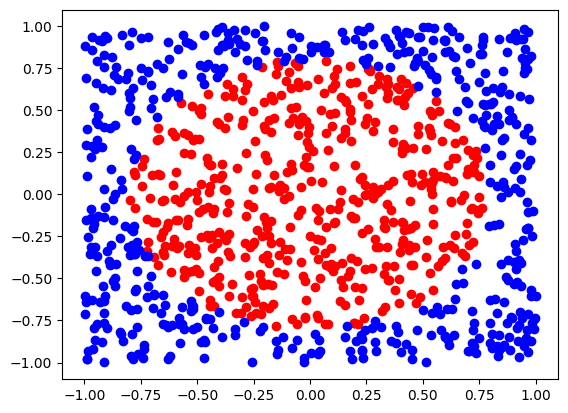

In [11]:
with open('Data/Homework_1/secret_data_x.csv', 'rb') as f:
    x = np.loadtxt(f, delimiter=',')
with open('Data/Homework_1/secret_data_y.csv', 'rb') as f:
    y = np.loadtxt(f, delimiter=',')

plt.figure()
plt.scatter(x[y==1, 0], x[y==1, 1], color='red')
plt.scatter(x[y==0, 0], x[y==0, 1], color='blue')
plt.show()

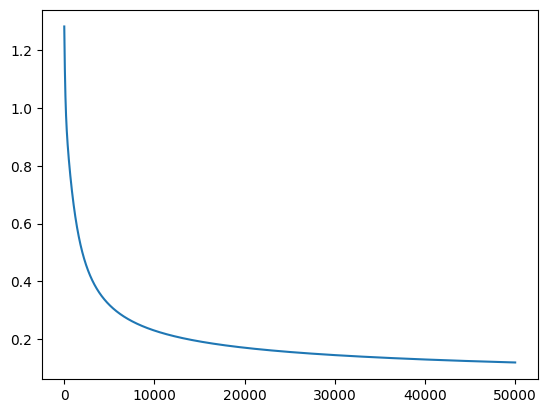

/var/folders/b7/8hhkzs5n5vx9gxwftcc2j9hh0000gn/T/ipykernel_83240/3044742340.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


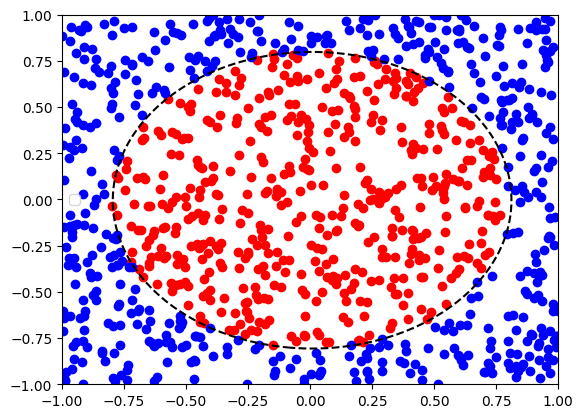

In [12]:
def featurize(x):
    """Take in x and return a new numpy array with the features you want"""
    # NOTE: Other solutions are possible
    return np.array([x[0], x[1], x[0]**2, x[1]**2, x[0]*x[1]])

# implement gradient descent on the negative log likelihood yourself
# DO NOT USE TORCH YET
num_iters = 50000
lr = 0.02

# initialize the weights
new_x = np.array([featurize(x_i) for x_i in x])
w = np.random.randn(new_x.shape[-1])
b = np.random.randn()

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def nll(x, y, w, b):
    pred = sigmoid(x @ w + b)
    return -np.mean(y * np.log(pred + 1e-15) + (1 - y) * np.log(1 - pred + 1e-15))

losses = []
for i in range(num_iters):
    # forward pass
    pred = sigmoid(new_x @ w + b)
    loss = nll(new_x, y, w, b)
    losses.append(loss)

    # backward pass
    grad_w = np.mean((pred - y)[:, None] * new_x, axis=0)
    grad_b = np.mean(pred - y)
    
    # update weights
    w -= lr * grad_w
    b -= lr * grad_b


plt.figure()
plt.plot(losses)
plt.show()

# plot the decision boundary. This will grid over the space and evaluate the model at each point. It then plots the boundary corresponding to where the model
# predicts a 50% probability of being in class 1. 
# If you're feeling fancy, vectorize it!
plt.figure()
plt.scatter(x[y==1, 0], x[y==1, 1], color='red')
plt.scatter(x[y==0, 0], x[y==0, 1], color='blue')
x_space = np.linspace(-1, 1, 100)
y_space = np.linspace(-1, 1, 100)
X_mesh, Y_mesh = np.meshgrid(x_space, y_space)
Z = np.zeros_like(X_mesh)
for i in range(100):
    for j in range(100):
        Z[i, j] = sigmoid(featurize(np.array([X_mesh[i, j], Y_mesh[i, j]])) @ w + b)
# create a level 0 contour with a label
plt.contour(X_mesh, Y_mesh, Z, levels=[0.5], colors='black', linestyles='dashed')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.legend()
plt.show()




# Question 2 - Pytorch practice
Now, we're going to redo linear regression using PyTorch tooling to see how it makes life easier. Later, we'll unpack some of the internals to see how it's actually doing this.

## Torch Modules
Torch allows us to define sequences of operations and wrap them all up in a class that can be called like a function. This is done by defining a class that inherits from `torch.nn.Module`. This class should have an `__init__` function that defines all the parameters of the model and a `forward` function that defines how the model is run.

```python
class ExampleModule(torch.nn.Module):
    def __init__(self):
        super(ExampleModule, self).__init__()
        self.linear = torch.nn.Linear(1, 1)
        
    def forward(self, x):
        return self.linear(x)
```
This class uses a linear layer to map from a 1-dimensional input to a 1-dimensional output. We can then call this model like a function. The invocation of this module forms a layer of a computational graph. 

```python
model = ExampleModule()
model(torch.tensor([1.0]))
```

So, going back to our example of a backwards call, we can pass some inputs through our module and use them to update the parameters of the model. This is done by calling `backward` on the output of the model. 

```python
model = ExampleModule()
x = torch.tensor([1.0], requires_grad=True)
y = model(x)
y.backward()
```

In [13]:
class ExampleModule(torch.nn.Module):
    def __init__(self):
        super(ExampleModule, self).__init__()
        # this is a linear layer. It takes in a feature of dimension 1, outputs a feature of dimension 1, and has a bias term.
        # so essentially, it represents the transformation w*x + b
        self.linear = torch.nn.Linear(in_features=1, out_features=1, bias=True)
        
    def forward(self, x):
        return self.linear(x)
    
model = ExampleModule()
print(model)
x = torch.tensor([1.0], requires_grad=True)
y = model(x)
y.backward()

# we can loop through model parameters like this
for param in model.parameters():
    print(param.grad)
# we can see that the gradient of y with respect to the parameter in the linear layer is 1.0. Does this make sense to you?

ExampleModule(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
tensor([[1.]])
tensor([1.])


## Now, lets illustrate what a training loop looks like in PyTorch for this model
We are going to make a really trivial loss function, trying to make the output of the model equal to 3. We'll then run a training loop to try to make the output of the model equal to 3.

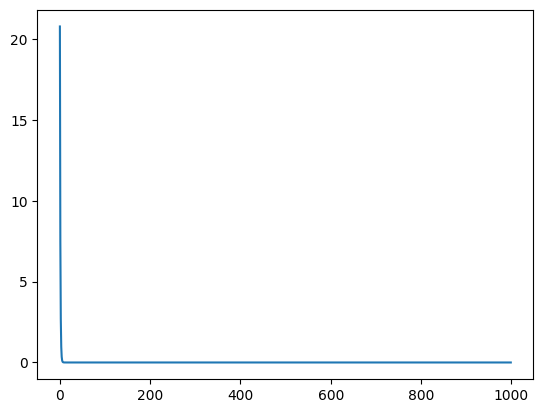

In [14]:
model = ExampleModule()
# note that we're setting requires_grad false here, this is because
# we're trying to take derivatives with respect to the parameters of the model
# not with respect to x
x = torch.tensor([[1.0]], requires_grad=False)
learning_rate = 0.1
losses = []
for i in range(1000):
    y = model(x)
    loss = (y-3)**2
    # note that .item is used to extract the value from a tensor and detach it 
    # from the computational graph. This ensure that you can't take derivatives through it.
    losses.append(loss.item())
    loss.backward()
    # we can update the weights using gradient descent
    # the torch.no_grad() is used to tell pytorch that we don't want to keep track of these operations in the computational graph
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
    # we need to zero out the gradients before the next iteration
    model.zero_grad()
plt.figure()
plt.plot(losses)
plt.show()

One **really** important thing to pay attention to in the above bit of code is the `model.zero_grad()`. In torch the gradients accumulate, meaning that they don't reset to zero after each iteration and are simply added to the previous value in .grad. This is useful in some cases, but in our case, we want to reset the gradients to zero after each iteration.

# Problem 2 - Implementing logistic regression in PyTorch
Having manually implemented linear regression, lets see how PyTorch makes it easier! In the following example, I've placed out a sketch of a logistic regression model. Your job is to fill in the missing parts and train the model on the dataset I've provided. Any section marked with `pass` should be filled in.

torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([100, 1])
torch.Size([1

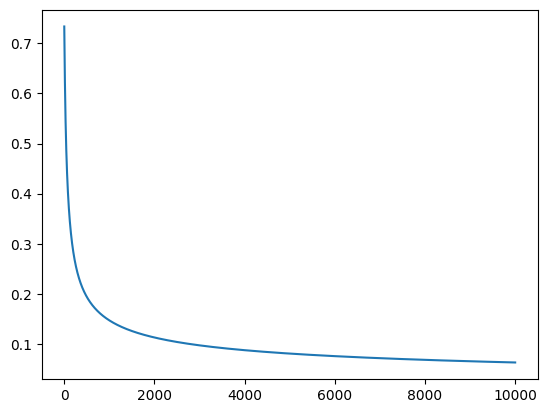

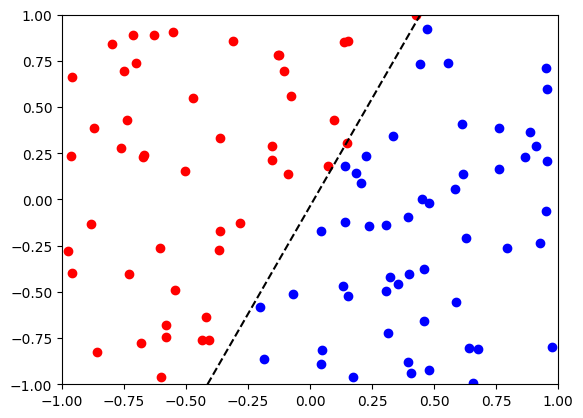

Parameter containing:
tensor([[-12.5940,   5.4031]], requires_grad=True)


In [30]:
# Implement logistic regression as a torch module
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(in_features=2, out_features=1, bias=True)
    def forward(self, x):
        return torch.sigmoid(self.linear(x))
        
with open('Data/Homework_1/linear_data_x.csv', 'rb') as f:
    x = np.loadtxt(f, delimiter=',')
with open('Data/Homework_1/linear_data_y.csv', 'rb') as f:
    y = np.loadtxt(f, delimiter=',')
    
x = torch.tensor(x, dtype=torch.float32)
# we need to reshape y to be a column vector
# WARNING: this is a really common mistake people made. 
# if you trace through the code, you'll see the problem.
# In short, x is (100, 2) dimensional and after you pass it through the model it is (100,1) dimensional
# but by default y is (100, ) dimensional.
# So, when we do something like y * torch.log(pred), we're actually doing a broadcast operation and the resultant shape is (100, 100)
# So, we need to make y (100, 1) dimensional so broadcasting doesn't happen.
# This is a common mistake in torch and numpy as beware of it.

y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
model = LogisticRegression()

def nll(x, y, model):
    pred = model(x)
    return -torch.mean(y * torch.log(pred + 1e-15) + (1 - y) * torch.log(1 - pred + 1e-15))

losses = []
learning_rate = 0.1
for i in range(10000):
    # fill in a torch learning loop here
    model.zero_grad()
    loss = nll(x, y, model)
    losses.append(loss.item())
    loss.backward()
    for param in model.parameters():
        param.data -= learning_rate * param.grad
    
plt.figure()
plt.plot(losses)
plt.show()

# Now we plot the predictions
y = y.squeeze()
plt.figure()
plt.scatter(x.numpy()[y==1, 0], x.numpy()[y==1, 1], color='red')
plt.scatter(x.numpy()[y==0, 0], x.numpy()[y==0, 1], color='blue')
x_space = np.linspace(-1, 1, 100)
y_space = np.linspace(-1, 1, 100)
X_mesh, Y_mesh = np.meshgrid(x_space, y_space)
Z = np.zeros_like(X_mesh)
for i in range(100):
    for j in range(100):
        Z[i, j] = model(torch.tensor([[X_mesh[i, j], Y_mesh[i, j]]], dtype=torch.float32)).item()
# create a level 0 contour with a label
plt.contour(X_mesh, Y_mesh, Z, levels=[0.5], colors='black', linestyles='dashed')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

print(model.linear.weight)



# Problem 3 - Practice with log-likelihoods
Generally, what we are going to try to learn a function that for a data-point, predicts that the true label is the actual label with high probability. Since I want you to get comfortable with this idea, we're going to do one example of this explicitly by showing how linear-least squares is a special case of maximizing the likelihood. 

In particular, we're going to make the following assumptions about the process that generated the data:
**The data is generated by the model $y = w^Tx + b + \epsilon$ where $\epsilon$ is some noise term that is normally distributed with mean 0 and variance $\sigma^2$.** Essentially, we can write 
$$p(y|x, w, b) = \mathcal{N}(w^Tx + b, \sigma^2)$$

The problem is such:
1. Form the likelihood over the data
2. Show that maximizing the likelihood is equivalent to minimizing the least-squares loss.

# 3.1 Solution
1. Okay, so, lets write out the likelihood of a single data-point. We have that $p(y|x, w, b) = \mathcal{N}(w^Tx + b, \sigma^2)$. So, the likelihood of a single data-point is given by $$p(y|x, w, b) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y - w^Tx - b)^2}{2\sigma^2}\right)$$
The reason we get this is that the data can be viewed as being sampled from a distribution with mean $w^Tx + b$ and variance $\sigma^2$. For a Gaussian distribution we have that the probability of a sample is 
$$p(z|\mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(z - \mu)^2}{2\sigma^2}\right)$$
and plugging in $y$ for $z$ and $w^Tx + b$ for $\mu$ we get the above expression.

The likelihood is the product of all of these data-points 

$$L(w,b) = \prod_{i=1}^N p(y_i|w,b,x_i) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y_i - w^Tx_i - b)^2}{2\sigma^2}\right)$$

2. Now rather than maximize the likelihood, we'll maximize the log likelihood. We know that this is the same but is more pleasant to work with. Converting the products to sums we have
$$\log L(w,b) = \sum_{i=1}^N \log p(y_i|w,b,x_i) = \sum_{i=1}^N \log \left(\frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(y_i - w^Tx_i - b)^2}{2\sigma^2}\right)\right)$$ 
and noting that the log of a product is the sum of the logs we have
$$\log L(w,b) = \sum_{i=1}^N \left(\log \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right) - \log\exp\left(\frac{(y_i - w^Tx_i - b)^2}{2\sigma^2}\right)\right)$$
Finally, note that the $\log(\exp(x)) = x$ and so the second term simplifies as 
$$\log L(w,b) = \sum_{i=1}^N \left(\log \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right) - \frac{(y_i - w^Tx_i - b)^2}{2\sigma^2}\right)$$
We also note that the first term, $\left(\log \left(\frac{1}{\sqrt{2\pi\sigma^2}}\right)\right)$ is a constant and so we can ignore it when maximizing the likelihood. This leaves us with 
$$\underset{w,b}{\max} \log L(w,b) = -\frac{1}{2\sigma^2}\sum_{i=1}^N (y_i - w^Tx_i - b)^2$$

Finally, we note that nothing in this maximization is affected if we remove $\frac{1}{2\sigma^2}$ from the equation. This gives us the least-squares loss function.

# "Problem" 4 - Lets get on the cluster!
We've set you up with an HPC account so you can learn how to use clusters. You have been provided approximately 200 computing hours that you can use for this class. If you run out, let me know!

## Step 1 - logging on
Read the [instructions about how to get onto HPC](https://sites.google.com/nyu.edu/nyu-hpc/accessing-hpc?authuser=0). To make your life easier, definitely read the section about SSH keys. This will save you having to type in your password every single time.

While you can ssh into the cluster from the command line, I generally use VSCode to connect to the cluster. This is a little bit easier to use and has a lot of nice features. You can find instructions on how to do this [here](https://code.visualstudio.com/docs/remote/ssh).

## Step 2 - getting your environment set up
Follow the instructions in the README to set up an environment on the cluster. You can use the same environment that you set up for this homework. This is temporary, we will later switch over to using Singularity which is a Docker clone often used on academic clusters. It's not 1-1 with learning to use Docker but it's close enough that a lot of the ideas will transfer.

## Step 3 - getting an interactive node
Most of the time, you're going to just launch a job and walk away. However, sometimes you want to interactively write some code and test it on a GPU or a machine with many CPUs before you actually launch the job. The useful tool here is what's called an `interactive job`. When you first log into the cluster you're on what's called the **login node**. This node has essentially no computational resources and you should never run code on it. 

**WARNING: DO NOT RUN CODE ON THE LOGIN NODE**. The login node is a shared resource and if you run code on it the cluster managers will be very sad.

Instead, you want to start an `interactive job`: this is a job that you can log into and run code on. To get an interactive job, you can run the following command

```bash
srun --account=tr_gy_8013-2024fa --partition=interactive --time=04:00:00 --pty /bin/bash
```
A GPU job with 1 V100 GPU for 4 hours
```bash
srun --account=tr_gy_8013-2024fa --partition=n1s8-v100-1 --gres=gpu:v100:1 --time=04:00:00 --pty /bin/bash
```
A GPU job with 2 V100 GPUs for 4 hours 
```bash
srun --account=tr_gy_8013-2024fa --partition=n1s16-v100-2 --gres=gpu:2 --pty /bin/bash
```
Note the structure of these commands:
- `--account=tr_gy_8013-2024fa` is the account that you're using. This is the account that I've set up for you to use. If you don't include this, you won't be able to run anything.
- `--partition=X` is the partition that you're using. Each partition represents some allocated amount of computational resources. We've set up three different partitions for you: `interactive`, `n1s8-v100-1`, and `n1s16-v100-2`. The first is a CPU partition and the second two are GPU partitions. The `n1s8-v100-1` partition has 1 V100 GPU and the `n1s16-v100-2` partition has 2 V100 GPUs.
- `--time=04:00:00` is the amount of time that you're requesting. This is in the format `days-hours:minutes:seconds`. If you don't include this, you'll get a very short amount of time.
- `--pty /bin/bash`: This command says that when you log on, it should open up a bash shell for you to work with. 
Finally, `srun` is what is called a SLURM command. There's more on this in the lecture 1 notes but in short SLURM is a system set up to manage the cluster resources. To launch jobs, inspect jobs, cancel jobs, etc. you'll use SLURM commands.

**Confirm that you can get an interactive node** by running the above commands and then you're done. When you're done with the node, type exit to return back to the login node. 

## Step 4: look at your storage
So by default when you're logged in you're placed into your home directory. However, your home directory only has 15GB of storage which is not very much at all. However, at `/scratch/<YOUR NET UD>` you have 5TB of storage. You're going to want to make sure that things are stored there instead.

## Step 5: launching a job
When you want to launch a job, the way you do it is by writing an SBATCH script. This is a script that tells the cluster what resources you need and what code you want to run. In this exercise we'll write an SBATCH script but generally there's lots of libraries, some of which we'll use in this course, to automate the writing of SBATCH files for you.
Here's an example of an SBATCH script that runs a python script. 

```bash
#!/bin/bash
# the account you're using
#SBATCH --account=tr_gy_8013-2024fa
# the partition you're using. This partition only has CPUs.
#SBATCH --partition=interactive
# how long the job should run for
#SBATCH --time=00:10:00
# a node is a bundle of computational resources. Most nodes on Greene have some number of CPUs and 
# up to 4 GPUs. So, if you wanted to use more than 4 GPUs (you won't in this class), you'd need two nodes.
#SBATCH --nodes=1
# if your job is launching multiple tasks in parallel, you make this more than 1
# I think it's unlikely you'll need this in this class
#SBATCH --ntasks=1
# how many CPUs the job needs. This number will depend a lot on the task. 
#SBATCH --cpus-per-task=1
# how much RAM the job needs. 
#SBATCH --mem=4G
# how many GPUs and what type of GPU to give to the job. Delete this if your job doesn't actually need a GPU.
#SBATCH --gres=gpu:1
# where the output logs will be written
#SBATCH --output=example.out
# where the error logs will be written
#SBATCH --error=example.err

# lets load up the conda environment and print hello world to the out file
conda activate dl_urban && python -c "print('Hello, World!')"
```

Now, copy this file to a new filer called YOUR_FILE_NAME.sh remove the line about GPUs and launch it. You can launch it by running
```bash
sbatch YOUR_FILE_NAME.sh
```
This will submit the job to the cluster and you can check on it by running `squeue $USER`. This will show you all the jobs that you have running. When the job is done, you'll see the output and error files in the directory where you launched the job.